# Para o grupo

Pessoal, fiz várias mudanças nos arquivos que estavam no git e gerei esse aqui. 

Tirei algumas funções que faziam comandos simples como abertura do Excel e leitura de uma coluna do dataframe. Acho que neste esquema de notebook fica mais fácil de entender quando estamos visualizando explicitamente o código.

Como estou usando no Colab (que apaga os arquivos utilizados - ex.: csv, png), fiz uma rotina para buscar os dados diretamente do git.

As wordclouds de estado e empresa, estou gerando somente baseada em frequencia. Não vejo necessidade de um textmining mais avançado para estes casos, a não ser a limpeza dos dados de empresa.

A limpeza dos dados de empresa, estou fazendo linha a linha, removendo stopwords e limpando os dados.

# Descrição

**Trabalho BI - NLP WordClouds - Tratamento de Base de Reclamações**

Professor: Leonardo Alfredo Forero Mendoza

Alunos: 

- Alaor de Carvalho Neto
- André Luis Maravilha
- Daniel Fidelis Marques
- Leonardo Cardoso Vicente
- Maicon Melo Alves

A base do trabalho são todas as reclamações fundamentadas que foram audiência no ano de 2017.

1- Por favor crie uma wordcloud para item:
- empresa
- estado
- serviço

2- Na coluna 'problema' retire os dados null

Sendo assim ao todo são 3 wordclouds para serem entregues em um arquivo word.

Códigos de referência da aula 8 e 9.


# Importação de Bibliotecas e definições iniciais

In [1]:
# Instalando biblioteca python-Levenshtein
!pip install python-Levenshtein

# Imports
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
import os
import matplotlib.pyplot as plt
import requests
import Levenshtein as lev
import gensim

from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from PIL import Image

# Downloads NLTK
nltk.download('stopwords')
nltk.download('punkt')

# Referências para os arquivos
URL_CSV_FILE = "https://github.com/danielfidelis/BIWORDCLOUD/raw/master/codigo/base%20reclama%C3%A7%C3%B5es.csv"
URL_TEMPLATE_IMG = "https://github.com/danielfidelis/BIWORDCLOUD/raw/master/codigo/dislike.png"
CLOUD_FILE = URL_TEMPLATE_IMG.split("/")[-1]

# Identificação de valores nulos
NULL_VALUE = "NULLVALUE"

# Tamnaho máximo de palavras na cloud
MAX_WORDS_CLOUD = 300

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Minhas stopwords
MINHAS_STOP_WORDS = [
    'solicita',
    'deseja',
    'bom',
    'dia',
    'etc',
    'etc.',
    's',
    'a',
    's/a',
    'ltda',
    'matriz',
    'sa',
    's.a.',
    's.a',
    'nao',
    NULL_VALUE.lower(),
]

# Funções gerais

## Função para downlad da imagem template


In [3]:
def download_cloud_img():
  if not os.path.isfile(CLOUD_FILE):
    # Realiza o download
    file = requests.get(URL_TEMPLATE_IMG, stream=True)
    dump = file.content
    with open(CLOUD_FILE,'wb') as f:
      f.write(dump)
    del dump


## Função para gerar wordcloud

In [4]:
def gerar_nuvem(obj):
  """
  Gera a nuvem baseada no tipo recebido
  texto ou dicionário de frequências
  """
  maskArray = np.array(Image.open(CLOUD_FILE))
  wordcloud = WordCloud(collocations=False, background_color = "#FFFFFF", max_words = MAX_WORDS_CLOUD, mask = maskArray, contour_width=3)
  if type(obj) == dict:
    wordcloud.generate_from_frequencies(obj)
  else: # Tipo = texto
    wordcloud.generate(obj)

  plt.figure(figsize=(12,10))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

## Função para identificação de palavras válidas
Executa as segintes tarefas:
- Eliminação de stop words de palavras em português
- Seleção somente de strings alfanúmericas
- Eliminação de palavras de minha lista de stop words


In [5]:
def palavra_valida(palavra, minha_stopwords): 
  if palavra not in nltk.corpus.stopwords.words('portuguese') and palavra not in minha_stopwords:
      return True

  return False

## Funções para realizar o processo de limpeza (remoção de stopwords, pontuação etc.)

### Função para processar cada linha do dataframe individualmente

Cria uma coluna nova com o texto "limpo"

In [6]:
def limpa_coluna_linha_df(df, coluna, coluna_clean):
  """
  Remove stopwords em cada linha do dataframe e coloca o resultado na coluna
  coluna_clean da respectiva linha
  """
  df[coluna_clean] = NULL_VALUE

  for idx, row in df.iterrows():
    # Verifica o valor
    item = row[coluna]

    # Exibe o progresso
    print("\r[{perc}%] {item}".format(item=item, perc=round(100*idx/len(df))), end="")

    # Tokeniza
    tokens = nltk.word_tokenize(item, language='portuguese')

    # Remove pontuação
    tokens = gensim.utils.simple_preprocess(str(tokens), deacc=True)

    # Remove stopwords da lista tokenizada
    tokens = [p for p in tokens if palavra_valida(p.lower(), MINHAS_STOP_WORDS)]
    
    # Transforma em texto e grava na coluna_clean
    texto = " ".join(tokens)
    if texto == "": texto = NULL_VALUE
    if texto.upper() == NULL_VALUE: texto = NULL_VALUE
    row[coluna_clean] = texto

  # Exibe o progresso
  print("\r[100%] Finalizada limpeza da coluna " + coluna)

  # Retorno
  return df

### Função para buscar todas as palavras em todas as linhas de uma coluna do dataframe

Retorna uma lista com as palavras processadas

In [7]:
def limpa_busca_palavras_coluna(df, coluna):
    texto = df[coluna].str.cat(sep=' ')
    tokens = nltk.word_tokenize(texto, language='portuguese')
    tokens = gensim.utils.simple_preprocess(str(tokens), deacc=True)

    palavras = []
    for palavra in tokens:
        if palavra_valida(palavra.lower(), MINHAS_STOP_WORDS):
            palavras.append(palavra)
    
    # texto_processado = pd.Series(texto_limpo).str.cat(sep=' ')

    return palavras

# Importação e análise descritiva dos dados

In [8]:
# Importa os dados
download_cloud_img()
df = pd.read_csv(URL_CSV_FILE, encoding="windows-1252", sep=";")
#df = df.head(500) # Para testes

# Retira espaços das colunas
[df.rename(columns = {c: c.strip()}, inplace=True) for c in df.columns]

[None, None, None, None, None, None, None, None]

In [9]:
# Verificando os dados
df.head()

,Regiao,estado,empresa,subsidiaria,area,serviço,problema,faixa etarea
0,Sudeste,SP,ITAÚ UNIBANCO S/A,BANCO ITAÚ/BANCO UNIBANCO,"BANCOS MÚLTIPLOS, COM CARTEIRA COMERCIAL",Outros Contratos,"Contrato (não cumprimento, alteração, transfer...",entre 31 a 40 anos
1,Sudeste,SP,CLARO S/A,NET,NaN,Telefonia Fixa ( Plano de Expansão / Compra e ...,Contrato - Rescisão/alteração unilateral,mais de 70 anos
2,Sudeste,SP,ELETROPAULO METROPOLITANA ELETRICIDADE DE S PAULO,ELETROPAULO METROPOLITANA,DISTRIBUIÇÃO DE ENERGIA ELÉTRICA,Energia Elétrica,PID - Pedido de Indenização por Danos Morais,entre 31 a 40 anos
3,Sudeste,SP,GNN GARAGENS LTDA - EPP,NETPARK.COM.BR,ESTACIONAMENTO DE VEÍCULOS,"Estacionamento ( Particular, Supermercado, Sho...","Vicio de qualidade (mal executado, inadequado,...",entre 31 a 40 anos
4,Sudeste,SP,CLARO S/A,CLARO / NET / EMBRATEL / CLAROTV,TELEFONIA MÓVEL CELULAR,Telefonia Fixa ( Plano de Expansão / Compra e ...,"Vicio de qualidade (mal executado, inadequado,...",entre 41 a 50 anos


## Valores distintos e valores faltantes das colunas a serem analisadas

Aqui conseguimos ver o percentual de valores faltantes nas colunas de análise, assim como a relação entre os valores únicos de cada série com o total de valores da série.

Quanto menor o percentual de valores distintos, indica que temos mais repetição de valores trazendo uma maior confiança para a proporção (tamanho) que será utilizada na wordcloud.

Podemos ver por exemplo que a coluna `problema` possui um alto índice de valores faltantes 21% e possui 167 valores distintos.

A coluna empresa quase não possui valores nulos, mas possui muitos valores distintos.

Identificamos dois problemas a serem explorados:

1. Alto percentual de valores únicos nas colunas empresa e subsidiaria
2. Alto percentual de valores faltantes na coluna problema

In [10]:
df_analise = df[['estado', 'empresa', 'subsidiaria', 'serviço', 'problema']].describe().T[['count', 'unique']]
df_analise['perc_unique'] = df_analise['unique'] / len(df)
df_analise['perc_null_values'] = 1 - df_analise['count'] / len(df)
df_analise

,count,unique,perc_unique,perc_null_values
estado,42307,17,0.000401825,0
empresa,42306,11214,0.265063,2.36368e-05
subsidiaria,35777,8864,0.209516,0.154348
serviço,42307,193,0.00456189,0
problema,33371,167,0.00394734,0.211218


## Explorando o percentual de valores distintos nas colunas `empresa` e `subsidiaria`

Analisando um pouco mais a fundo, verificamos que existem casos da mesma empresa aparecer com nomes variados, como o exemplo abaixo (variação do acento):

- `BANCO BRADESCO CARTOES`
- `BANCO BRADESCO CARTÔES`
- `BANCO BRADESCO CARTÕES`

Essa situação pode resultar em um resultado impreciso na wordcloud, já que o algoritmo entenderá cada um dos termos acima como diferentes.

Vamos tratar este problema pela biblioteca `gensim` implementada nas funções de limpesa e com o método Levenshtein, substituindo palavras "similares" pela mesma palavra.

Para isso, definimos realizar o seguinte processamento para cada linhas das colunas empresa e subsidiária

1. Realizar um tratamento inicial, removendo pontuação e stopwords
2. Tokenizar todas as palavras existentes coluna na variável `lista_palavras`
3. Cada palavra da lista será comparada à lista completa identificando se existe similaridade
 - Nesse processo é criado um dicionário para guardar as palavras similares
 - Definido os seguintes parâmetros:
    - Processar palavras com tamanho >= 7
    - Substituir a palavra caso a distância de Levenshtein seja pelo menos 2

In [11]:
def processa_levenshtein(lista_palavras):
  """
  Compara cada palavra com a lista completa e associa uma palavra a outra caso
  esteja dentro da distância mínima
  """
  # Parâmetros
  MIN_LEN = 7
  MIN_DISTANCE = 2

  # Dicionário de associação
  dic = {}

  # Processa a lista
  for p in lista_palavras:
    # Verifica se a palavra possui o tamanho mínimo
    if len(p) < MIN_LEN:
      dic[p] = p
      continue

    # Verifica se a palavra já existe
    if p in dic:
      continue

    # A palavra equivalente inicial é a própria palava
    peq = p

    # Percorre cada palavra já processada e busca se existe alguma equivalente
    for pdic in dic:
      if len(pdic) < MIN_LEN:
        continue

      if lev.distance(p, pdic) <= MIN_DISTANCE:
        peq = pdic
        print("\r{p} ~ {peq}".format(p=p, peq=peq), end="")
        break

    # Insere a palavra no dicionário com sua palavra equivalente
    dic[p] = peq

  # Retorno
  print("\r", end="")
  return dic


In [12]:
# Identifica valores faltantes para evitar erro no tratamento
df['empresa'].fillna(NULL_VALUE, inplace=True)
df['subsidiaria'].fillna(NULL_VALUE, inplace=True)
df['problema'].fillna(NULL_VALUE, inplace=True)
df['serviço'].fillna(NULL_VALUE, inplace=True)

In [13]:
# Realiza a limpeza em cada linha das colunas
# limpa_coluna_linha_df :
# Remove stopwords em cada linha do dataframe e coloca o resultado na coluna
# coluna_clean da respectiva linha
df = limpa_coluna_linha_df(df, 'empresa', 'empresa_clean')
df = limpa_coluna_linha_df(df, 'subsidiaria', 'subsidiaria_clean')
df = limpa_coluna_linha_df(df, 'problema', 'problema_clean')
df = limpa_coluna_linha_df(df, 'serviço', 'serviço_clean')

[100%] Finalizada limpeza da coluna empresa
[100%] Finalizada limpeza da coluna subsidiaria
[100%] Finalizada limpeza da coluna problema
[100%] Finalizada limpeza da coluna serviço


In [14]:
def busca_ordena_palavras_coluna(df, coluna):
  """
  Verifica todas as palavras existentes em uma coluna e retorna uma lista
  ordenada pela frequencia de repetição de cada palavra, mantendo no topo as
  mais frequentes.

  Manter no topo da lista as palavras mais frequentes indicará para a função
  seguinte que no caso de encontrar uma palavra equivalente a outra, deve ser
  mantida a que possui maior frequencia no dataset
  """
  # Busca as palavras de cada coluna
  print("busca_ordena_palavras_coluna: " + coluna)
  palavras = limpa_busca_palavras_coluna(df, coluna)

  # Ordena colocando no topo as que mais se repetem
  # Essa ordenação garantirá que a palavra mais representativa (que mais se repete)
  # seja usada para representar as que sejam similares a ela
  palavras_repeticao = [[p] for p in list(set(palavras))]
  [p.append(palavras.count(p[0])) for p in palavras_repeticao]
  palavras_repeticao = sorted(palavras_repeticao, key=lambda x: x[1], reverse=True)
  palavras = [p[0] for p in palavras_repeticao]

  return palavras

def substitui_palavras_coluna_linha_df(df, coluna_clean, palavras):
  """
  Verifica em cada linha do dataframe as palavras existentes e a substitui pela
  palavra equivalente com base no método da distância de Levenshtein
  """
  # Verifica a associação das palavras
  dic = processa_levenshtein(palavras)

  # Substitui cada palavra por sua respectiva no dataframe
  for idx, row in df.iterrows():
    # Verifica o valor
    item = row[coluna_clean]

    # Exibe o progresso
    print("\r[{perc}%] {item}".format(item=item, perc=round(100*idx/len(df))), end="")

    # Verifica as palavras
    palavras_linha = item.split(" ")
    #print(palavras)

    # Substitui as palavras por sua respectiva no dicionário
    for idx, p in enumerate(palavras_linha):
      if p in dic:
        palavras_linha[idx] = dic[p]

    # Gera o texto concatenado das palavras
    texto = " ".join(palavras_linha)
    if item != texto:
      print("\r{item} = {texto}".format(item=item, texto=texto), end="")
    row[coluna_clean] = texto

  return df

palavras_empresas = busca_ordena_palavras_coluna(df, 'empresa_clean')
palavras_subsidiarias = busca_ordena_palavras_coluna(df, 'subsidiaria_clean')
palavras_problema = busca_ordena_palavras_coluna(df, 'problema_clean')
palavras_servico = busca_ordena_palavras_coluna(df, 'serviço_clean')

df = substitui_palavras_coluna_linha_df(df, 'empresa_clean', palavras_empresas)
df = substitui_palavras_coluna_linha_df(df, 'subsidiaria_clean', palavras_subsidiarias)
df = substitui_palavras_coluna_linha_df(df, 'problema_clean', palavras_problema)
df = substitui_palavras_coluna_linha_df(df, 'serviço_clean', palavras_problema)

busca_ordena_palavras_coluna: empresa_clean
busca_ordena_palavras_coluna: subsidiaria_clean
busca_ordena_palavras_coluna: problema_clean
busca_ordena_palavras_coluna: serviço_clean
[100%] escola pre graus superior

#### Visualizando as diferenças nos valores de cada coluna antes e depois do processamento de limpeza

Podemos ver que as duas colunas foco desta análise (empresa e subsidiaria) foram as mais afetadas neste processamento.
- Coluna empresa: **2.002** valores similares agrupados (11.214 antes do processamento e 9.212 depois)
- Coluna subsidiaria: **950** valores similares agrupados (8.864 antes do processamento e 7.914 depois)

In [15]:
df_analise_clean = df[['empresa_clean', 'subsidiaria_clean', 'problema_clean', 'serviço_clean']].describe().T[['count', 'unique']]
df_analise_clean['perc_unique'] = df_analise_clean['unique'] / len(df)
df_analise_clean['perc_null_values'] = 1 - df_analise_clean['count'] / len(df)
df_analise_clean[['unique', 'perc_unique']]

,unique,perc_unique
empresa_clean,9210,0.217694
subsidiaria_clean,7914,0.187061
problema_clean,163,0.00385279
serviço_clean,192,0.00453826


In [16]:
df_analise.loc[['empresa', 'subsidiaria', 'problema', 'serviço']][['unique', 'perc_unique']]

,unique,perc_unique
empresa,11214,0.265063
subsidiaria,8864,0.209516
problema,167,0.00394734
serviço,193,0.00456189


## Explorando os valores faltantes na coluna problema

Aqui fazemos uma verificação cruzada entre a coluna problema e as demais colunas de análise buscando identificar algum padrão para os valores faltantes

In [34]:
# Cria cópia do dataframe e cria coluna para identificar valores faltantes
df_prob = df.copy()
df_prob['VALOR_NULO_PROB'] = "PRESENTE"
df_prob.loc[
            (df_prob['problema'].isnull()) |
            (df_prob['problema'].str.upper()==NULL_VALUE),
            'VALOR_NULO_PROB'] = "NULO"

# Verificando os valores
df_prob.groupby(['problema'])['problema'].count().sort_values(ascending=False)

problema
NULLVALUE                                                          8936
Produto com vício                                                  6043
Cobrança indevida/abusiva                                          4695
Cobrança indevida.                                                 3272
Peso, volume e quantidade                                          1726
                                                                   ... 
Duvidas sobre cobranças (taxas etc.)                                  1
Problemas com crédito consignado                                      1
Denuncia vazia                                                        1
Revisional de aluguel                                                 1
Acidente de Consumo (causou danos pessoais, físicos, mal estar)       1
Name: problema, Length: 168, dtype: int64

In [35]:
def cruza_colunas(df, coluna):
  """
  Verifica a distribuição dos valores faltantes
  """
  df_group = df.groupby([coluna, 'VALOR_NULO_PROB'])[coluna].agg('count').to_frame()
  df_group.rename(columns={coluna: 'qtde'}, inplace=True)
  df_group.reset_index(inplace=True)
  df_group = pd.pivot_table(df_group, values='qtde', index=coluna, columns='VALOR_NULO_PROB', fill_value=0)
  df_group.reset_index(inplace=True)
  df_group['PERC_NULO_INTERNO'] = df_group['NULO'] / (df_group['NULO'] + df_group['PRESENTE'])
  df_group['PERC_NULO_GERAL'] = df_group['NULO'] / (sum(df_group['NULO']) + sum(df_group['PRESENTE']))
  
  
  return df_group.sort_values(by='PERC_NULO_GERAL', ascending=False)

### Problema X Estado

Aqui vemos que 8% do total de valores nulos na coluna problema estão concetrados no estado GO.

Uma informação interessante é que a coluna problema possui **21%** de dados faltantes e apenas os 5 primeiros estados já representam **18%** dos valores faltantes de `problema`.

Este estado concentra também 47% dos valores nulos na coluna problema considerando ocorrência apenas no próprio estado.

In [36]:
cruza_colunas(df_prob, 'estado').head()

VALOR_NULO_PROB,estado,NULO,PRESENTE,PERC_NULO_INTERNO,PERC_NULO_GERAL
2,GO,3687,4077,0.474884,0.087149
11,RN,1452,2621,0.356494,0.034321
4,MG,1262,2198,0.364740,0.029830
6,MT,753,3219,0.189577,0.017798
15,SP,655,7472,0.080596,0.015482


### Demais colunas

In [37]:
cruza_colunas(df_prob, 'empresa_clean').head()

VALOR_NULO_PROB,empresa_clean,NULO,PRESENTE,PERC_NULO_INTERNO,PERC_NULO_GERAL
1404,caixa economica federal,200,510,0.281690,0.004727
8388,telemar norte leste,198,333,0.372881,0.004680
1987,claro,164,1050,0.135091,0.003876
1733,centrais eletricas,149,0,1.000000,0.003522
7562,samsung eletronica amazonia,142,522,0.213855,0.003356


In [38]:
cruza_colunas(df_prob, 'subsidiaria_clean').head()

VALOR_NULO_PROB,subsidiaria_clean,NULO,PRESENTE,PERC_NULO_INTERNO,PERC_NULO_GERAL
0,NULLVALUE,1340,5334,0.200779,0.031673
1602,celpa,149,1,0.993333,0.003522
7117,telemar oi fixo movel oi paggo velox oi net,124,0,1.000000,0.002931
5387,oi,107,459,0.189046,0.002529
6431,samsung,88,360,0.196429,0.002080


In [39]:
cruza_colunas(df_prob, 'serviço_clean').head()

VALOR_NULO_PROB,serviço_clean,NULO,PRESENTE,PERC_NULO_INTERNO,PERC_NULO_GERAL
174,telefone convencional celular interfone,1113,4036,0.216158,0.026308
175,telefonia celular,524,2513,0.172539,0.012386
25,banco comercial,492,1821,0.212711,0.011629
41,cartao credito,472,1802,0.207564,0.011157
132,outros contrato,440,1420,0.236559,0.010400


## Explorando valores faltantes na coluna `subsidiaria`

In [40]:
# Cria cópia do dataframe e cria coluna para identificar valores faltantes
df_sub = df.copy()
df_sub['VALOR_NULO_PROB'] = "PRESENTE"
df_sub.loc[
            (df_sub['subsidiaria_clean'].isnull()) |
            (df_sub['subsidiaria_clean'].str.upper()==NULL_VALUE),
            'VALOR_NULO_PROB'] = "NULO"

# Verificando os valores
df_sub.groupby(['subsidiaria_clean'])['subsidiaria_clean'].count().sort_values(ascending=False)

subsidiaria_clean
NULLVALUE                      6674
vivo telefonica                 803
oi                              566
motorola                        546
tim celular                     483
                               ... 
mb engenharia spe                 1
mb vicent comercio servicos       1
mc moveis planejados              1
mc pedras                         1
iuryrico corpo saude              1
Name: subsidiaria_clean, Length: 7914, dtype: int64

In [41]:
cruza_colunas(df_sub, 'empresa_clean')

VALOR_NULO_PROB,empresa_clean,NULO,PRESENTE,PERC_NULO_INTERNO,PERC_NULO_GERAL
1489,cardif brasil seguros garantias,162,114,0.586957,0.003829
8451,tim celular,104,719,0.126367,0.002458
1404,caixa economica federal,91,619,0.128169,0.002151
874,banco brasil,83,426,0.163065,0.001962
853,banco bmg,82,284,0.224044,0.001938
...,...,...,...,...,...
3508,fabiana aleixo del pino mendonca,0,1,0.000000,0.000000
3507,fabbitur transportes turismo,0,2,0.000000,0.000000
3506,fa marinho fa colchoes,0,1,0.000000,0.000000
3504,extravagancias modas epp,0,1,0.000000,0.000000


In [42]:
cruza_colunas(df_sub, 'estado')

VALOR_NULO_PROB,estado,NULO,PRESENTE,PERC_NULO_INTERNO,PERC_NULO_GERAL
15,SP,1361,6766,0.167466,0.032170
2,GO,1039,6725,0.133823,0.024559
11,RN,896,3177,0.219985,0.021179
4,MG,667,2793,0.192775,0.015766
5,MS,665,4058,0.140800,0.015718
14,SC,497,1458,0.254220,0.011747
6,MT,452,3520,0.113797,0.010684
12,RO,423,1634,0.205639,0.009998
0,CE,407,1359,0.230464,0.009620
10,PI,125,2028,0.058059,0.002955


In [43]:
cruza_colunas(df_sub, 'serviço_clean')

VALOR_NULO_PROB,serviço_clean,NULO,PRESENTE,PERC_NULO_INTERNO,PERC_NULO_GERAL
174,telefone convencional celular interfone,838,4311,0.162750,0.019808
41,cartao credito,462,1812,0.203166,0.010920
25,banco comercial,443,1870,0.191526,0.010471
90,financeira,343,1090,0.239358,0.008107
132,outros contrato,314,1546,0.168817,0.007422
...,...,...,...,...,...
102,informacoes sobre procon,0,4,0.000000,0.000000
97,graos cereais feijao grao bico arroz farelo tr...,0,3,0.000000,0.000000
93,frutas hortalicas legumes verduras cebola cabe...,0,1,0.000000,0.000000
86,farinaceos fuba polvilho,0,1,0.000000,0.000000


In [44]:
cruza_colunas(df_sub, 'problema_clean')

VALOR_NULO_PROB,problema_clean,NULO,PRESENTE,PERC_NULO_INTERNO,PERC_NULO_GERAL
0,NULLVALUE,1340,7603,0.149838,0.031673
111,produto vicio,1047,4996,0.173258,0.024748
23,cobranca indevida,647,2625,0.197738,0.015293
95,peso volume quantidade,351,1375,0.203360,0.008296
79,garantia abrangencia cobertura,292,1146,0.203060,0.006902
...,...,...,...,...,...
135,rotulagem lingua estrangeira,0,3,0.000000,0.000000
134,revisional aluguel,0,1,0.000000,0.000000
125,recusa receber pagamento nota promissoria carne,0,9,0.000000,0.000000
126,recusa recebimento aluguel prestacao,0,1,0.000000,0.000000


# Geração de wordclouds

## Estado

No caso da wordcloud de estados, o processamento está sendo feito levando em consideração a frequência normalizada em que cada estado aparece na respectiva coluna do dataframe.

Não são realizados os processos de tokenização e remoção de stopwords.

Obs.: não vi diferença visual gerando os dados normalizados ou não. De qualquer forma, por garantia mantive o código `.transform(lambda x: (x - x.mean()) / x.std())` comentado.

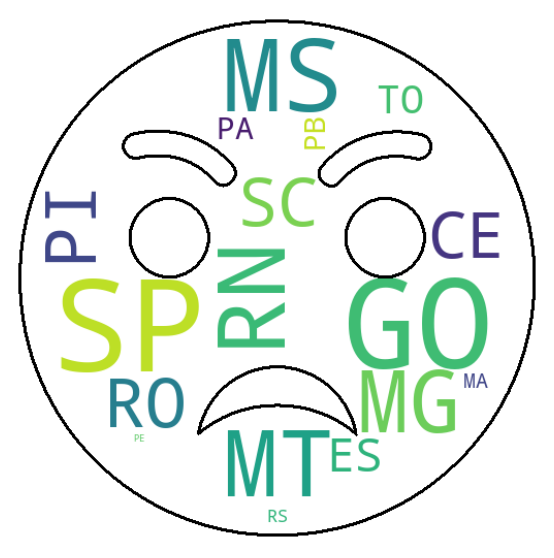

In [45]:
# Gera um dicionário com a frequencia normalizada de cada estado
df_group = df.loc[df['estado'].str.upper()!=NULL_VALUE].groupby(['estado'])['estado'].count()
#df_group = df_group.transform(lambda x: (x - x.mean()) / x.std())
dic_estado = df_group.to_dict()

# Gera a nuvem
gerar_nuvem(dic_estado)

## Empresa

### Sem nenhum tratamento nos dados

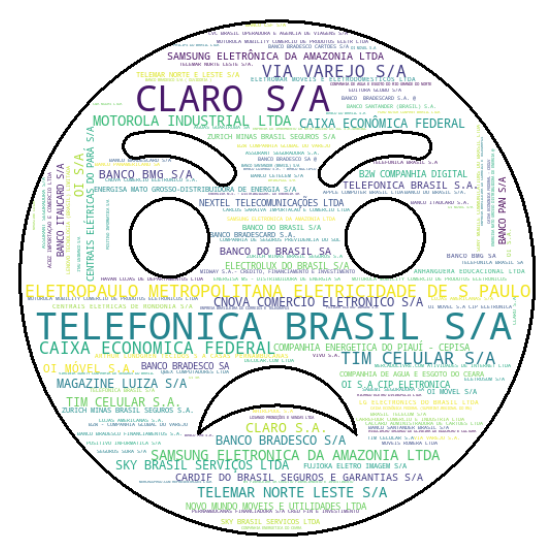

In [46]:
# Identifica valores faltantes para evitar erro no tratamento
df['empresa'].fillna(NULL_VALUE, inplace=True)

# Gera um dicionário com a frequencia normalizada
df_group = df.loc[df['empresa'].str.upper()!=NULL_VALUE].groupby(['empresa'])['empresa'].count()
#df_group = df_group.transform(lambda x: (x - x.mean()) / x.std())
dic_empresa = df_group.to_dict()

# Gera a nuvem
gerar_nuvem(dic_empresa)

### Com dados "limpos"

Executa o processo de tokenização e remoção de stopwords em cada linha da coluna `empresa`.

Um exemplo da diferença que reforça a qualidade da limpeza preliminar nos dados é a exibição da empresa `SAMSUNG ELETRONICA AMAZONIA`, que fica em evidência na wordcloud com os dados limpos e pouco perceptível na wordclou sem tratamento dos dados.

Outra diferença é que a wordcloud acima exibe empresas "repetidas", problema que foi tratado no processo de limpeza dos dados.

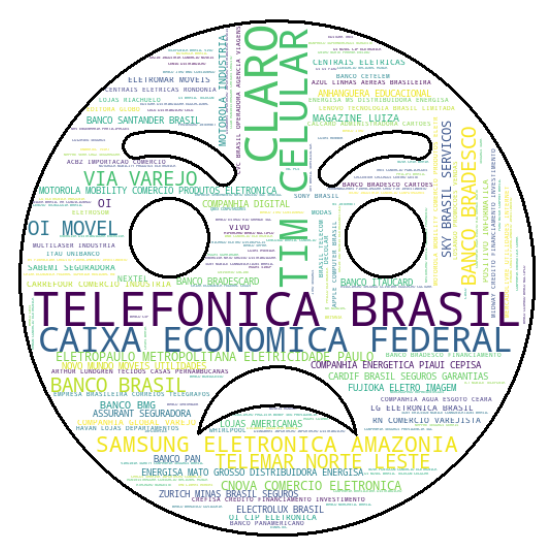

In [47]:
# Gera um dicionário com a frequencia normalizada
df['empresa_clean'] = df['empresa_clean'].str.upper()
df_group = df.loc[df['empresa_clean'].str.upper()!=NULL_VALUE].groupby(['empresa_clean'])['empresa_clean'].count()
#df_group = df_group.transform(lambda x: (x - x.mean()) / x.std())
dic_empresa = df_group.to_dict()

# Gera a nuvem
gerar_nuvem(dic_empresa)

## Subsidiária

### Sem tratamento nos dados

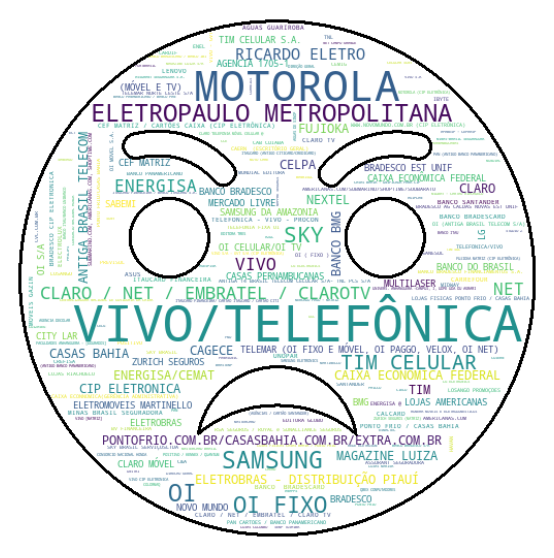

In [48]:
# Identifica valores faltantes para evitar erro no tratamento
df['subsidiaria'].fillna(NULL_VALUE, inplace=True)

# Gera um dicionário com a frequencia normalizada
df_group = df.loc[df['subsidiaria'].str.upper()!=NULL_VALUE].groupby(['subsidiaria'])['subsidiaria'].count()
#df_group = df_group.transform(lambda x: (x - x.mean()) / x.std())
dic_freq = df_group.to_dict()

# Gera a nuvem
gerar_nuvem(dic_freq)

### Com dados "limpos"

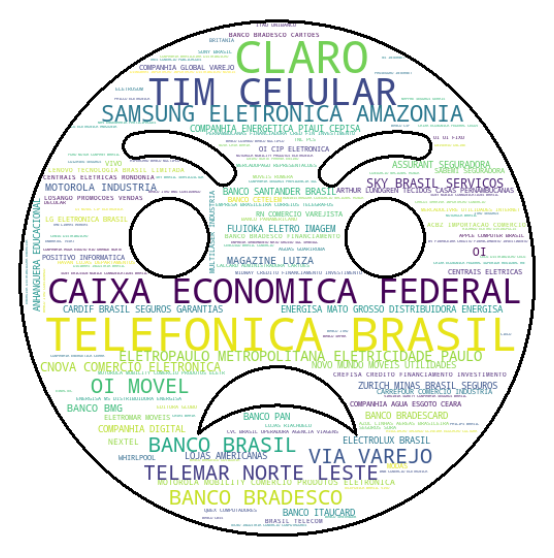

In [49]:
# Identifica valores faltantes para evitar erro no tratamento
df['subsidiaria_clean'].fillna(NULL_VALUE, inplace=True)

# Gera um dicionário com a frequencia normalizada
df['subsidiaria_clean'] = df['empresa_clean'].str.upper()
df_group = df.loc[df['subsidiaria_clean'].str.upper()!=NULL_VALUE].groupby(['subsidiaria_clean'])['subsidiaria_clean'].count()
#df_group = df_group.transform(lambda x: (x - x.mean()) / x.std())
dic_freq = df_group.to_dict()

# Gera a nuvem
gerar_nuvem(dic_freq)

## Serviço e problema

Verificamos que o tratamento de dados feito para empresa (manter o texto com o nome completo) não fica adequado para as colunas problema e serviço, como pode ser observado nas wordclouds a seguir (pouco aproveitamento dos espaços devido ao longo tamanho das strings).

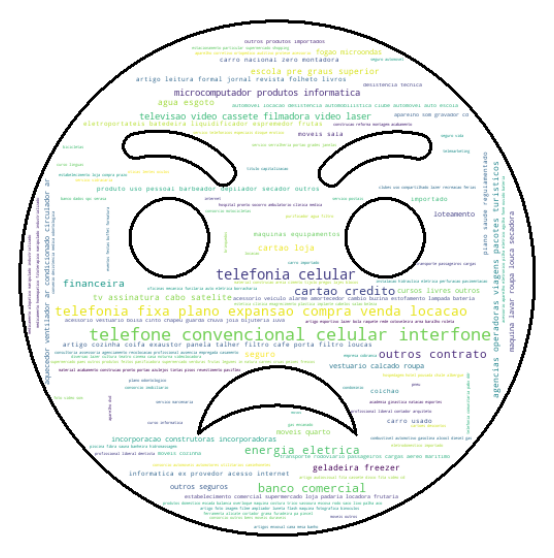

In [50]:
# Gera um dicionário com a frequencia normalizada
df_group = df.loc[df['serviço_clean'].str.upper()!=NULL_VALUE].groupby(['serviço_clean'])['serviço_clean'].count()
#df_group = df_group.transform(lambda x: (x - x.mean()) / x.std())
dic_freq = df_group.to_dict()

# Gera a nuvem
gerar_nuvem(dic_freq)

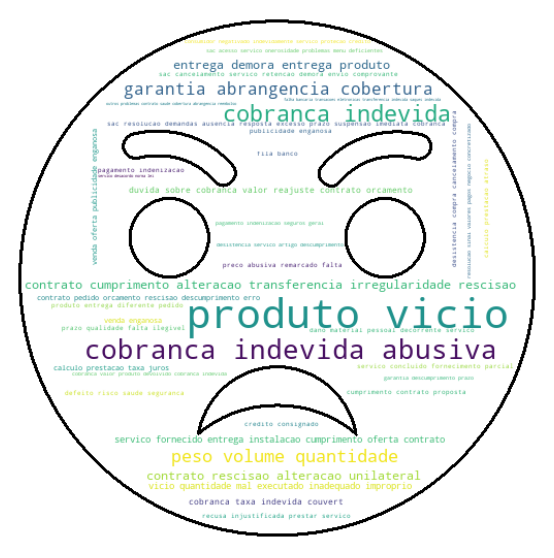

In [51]:
# Gera um dicionário com a frequencia normalizada
df_group = df.loc[df['problema_clean'].str.upper()!=NULL_VALUE].groupby(['problema_clean'])['problema_clean'].count()
#df_group = df_group.transform(lambda x: (x - x.mean()) / x.std())
dic_freq = df_group.to_dict()

# Gera a nuvem
gerar_nuvem(dic_freq)

## Explorando os dados das colunas problema e serviço

Aqui verificamos que o tamanho médio da string das colunas problema e serviço é maior que o da outras colunas.

Outro fator importante é que quantidade total de tokens dessas colunas é bem menor do que as outras.

Decidimos então gerar as wordclouds de serviço e problema usando como palava cada token existente em cada coluna, representados por sua frequencia

In [52]:
# Lista os tamanhos de cada linha do dataframe
len_empresa =  list(df['empresa_clean'].str.len())
len_subsidiaria = list(df['subsidiaria_clean'].str.len())
len_problema = list(df['problema_clean'].str.len())
len_servico = list(df['serviço_clean'].str.len())

# Coloca os tamanhos num dataframe para análise
list_len = []
for e, su, p, se in zip(len_empresa, len_subsidiaria, len_problema, len_servico):
  list_len.append([e, su, p, se])

df_len = pd.DataFrame(data=list_len, columns=['empresa', 'subsidiaria', 'problema', 'serviço'])
print("Tamnaho médio das strings das colunas")
df_len.describe()

Tamnaho médio das strings das colunas


,empresa,subsidiaria,problema,serviço
count,42307.000000,42307.000000,42307.000000,42307.000000
mean,22.243388,22.243388,25.700853,28.707022
std,11.094691,11.094691,17.818601,18.631150
min,2.000000,2.000000,8.000000,4.000000
25%,14.000000,14.000000,13.000000,15.000000
50%,21.000000,21.000000,22.000000,20.000000
75%,29.000000,29.000000,30.000000,39.000000
max,85.000000,85.000000,114.000000,144.000000


In [53]:
print("Tokens em empresas: {0}".format(len(palavras_empresas)))
print("Tokens em subsidiarias: {0}".format(len(palavras_subsidiarias)))
print("Tokens em problemas: {0}".format(len(palavras_problema)))
print("Tokens em serviço: {0}".format(len(palavras_servico)))


Tokens em empresas: 8328
Tokens em subsidiarias: 6664
Tokens em problemas: 374
Tokens em serviço: 656


### Gerando as wordclouds baseada nos tokens existentes

In [54]:
# Busca as palavras existentes em cada coluna
data_servico = limpa_busca_palavras_coluna(df, 'serviço_clean')
data_problema = limpa_busca_palavras_coluna(df, 'problema_clean')

In [55]:
# Compondo texto para a WordCloud
servico_txt = " ".join([l for l in data_servico])
problema_txt = " ".join([l for l in data_problema])

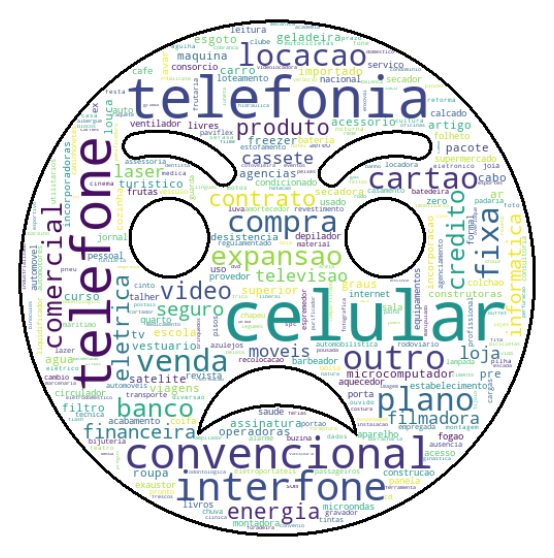

In [56]:
# Gerando wordcloud de serviço
gerar_nuvem(servico_txt)

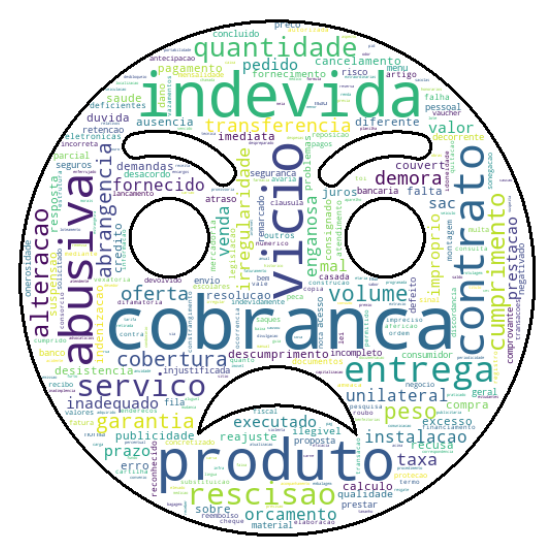

In [57]:
gerar_nuvem(problema_txt)

## Criando uma cloud de estados e completando "espaços vazios" com palavras de problema e serviço

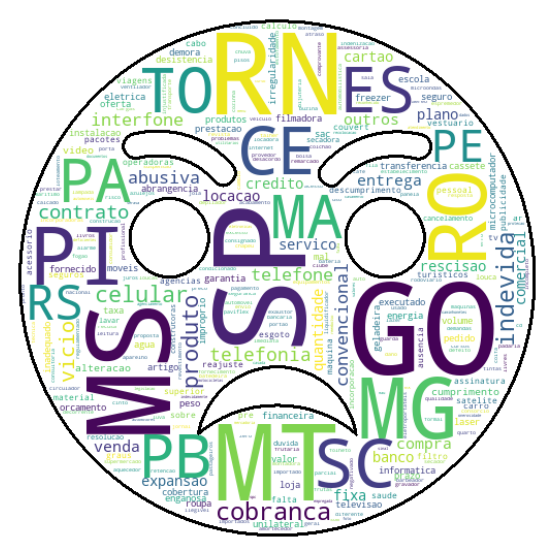

In [58]:
# Preenchendo os espaços "vazios" da cloud de estado com palavras existentes em 
# serviço e problema, mantendo estado em evidência

# Verifica valores de estado
df_group = df.loc[df['estado'].str.upper()!=NULL_VALUE].groupby(['estado'])['estado'].count()

# Verifica frequencias de problema + serviço
dic_serv_prob = {p: 0 for p in data_servico + data_problema}
for p in data_servico + data_problema: dic_serv_prob[p] += 1

# Verifica o item com mais repetição em problema e serviço e soma este valor a
# toda série de estados
max_rep = max(dic_serv_prob[p] for p in dic_serv_prob)
df_group += max_rep

# Adiciona os serviços e problemas ao dataframe e gera o dicionário de frequencia
for x in dic_serv_prob: df_group.loc[x] = dic_serv_prob[x]
dic_estado = df_group.to_dict()

# Gera a nuvem
gerar_nuvem(dic_estado)